# Demand Forecasting on Walmart Dataset

## Neccesary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import stats
import numpy as np
import seaborn as sns
import pickle
import math
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import random
import itertools

## Data Preprocessing Functions

In [2]:
def create_moving_averages(df_list):
    new_df =[]
    for i in range (0,len(df_list)):
        # Create a copy of the dataframe to avoid modifying the original
        df = df_list[i].copy()
        # Sort the dataframe by date
        df = df.sort_values('Date')
        # Create a new column for the moving averages
        df['1mRos'] = df['Weekly_Sales'].rolling(4, min_periods=1).mean()
        df['2mRos'] = df['Weekly_Sales'].rolling(12, min_periods=1).mean()
        df['3mRos'] = df['Weekly_Sales'].rolling(1, min_periods=1).mean()
        # If we have missing weeks, fill with median value
        df['1mRos'].fillna(df['Weekly_Sales'].median(), inplace=True)
        df['2mRos'].fillna(df['Weekly_Sales'].median(), inplace=True)
        df['3mRos'].fillna(df['Weekly_Sales'].median(), inplace=True)
        new_df.append(df)
    return new_df

In [3]:
def create_trigonometric_columns(df_list):
    new_df = []
    for i in range (0,len(df_list)):
    # Create a copy of the dataframe to avoid modifying the original
        df = df_list[i].copy()
        # Create sine and cosine columns for Year, Month and Day
        df['Year_sin'] = df['Year'].apply(lambda x: math.sin(2*math.pi*x/2023))
        df['Year_cos'] = df['Year'].apply(lambda x: math.cos(2*math.pi*x/2023))
        df['Month_sin'] = df['Month'].apply(lambda x: math.sin(2*math.pi*x/12))
        df['Month_cos'] = df['Month'].apply(lambda x: math.cos(2*math.pi*x/12))
        df['Day_sin'] = df['Day'].apply(lambda x: math.sin(2*math.pi*x/31))
        df['Day_cos'] = df['Day'].apply(lambda x: math.cos(2*math.pi*x/31))
        df['Week_of_Year_sin'] = df['Week_of_Year'].apply(lambda x: math.cos(2*math.pi*x/56))
        df['Week_of_Year_cos'] = df['Week_of_Year'].apply(lambda x: math.cos(2*math.pi*x/56))
        new_df.append(df)
    return new_df

In [4]:
def delete_useless_cols(df_list,promo):
    for i in range (0,len(df_list)):
        df_list[i] = df_list[i].drop(['Store'], axis=1)
        df_list[i] = df_list[i].drop(['Dept'], axis=1)
        df_list[i] = df_list[i].drop(['Type'], axis=1)
        df_list[i] = df_list[i].drop(['Size'], axis=1)
        df_list[i] = df_list[i].drop(['Day'], axis=1)
        df_list[i] = df_list[i].drop(['Month'], axis=1)
        df_list[i] = df_list[i].drop(['Week_of_Year'], axis=1)
        if promo == 'No_Promo':
            df_list[i] = df_list[i].drop(['MarkDown1'], axis=1)
            df_list[i] = df_list[i].drop(['MarkDown2'], axis=1)
            df_list[i] = df_list[i].drop(['MarkDown3'], axis=1)
            df_list[i] = df_list[i].drop(['MarkDown4'], axis=1)
            df_list[i] = df_list[i].drop(['MarkDown5'], axis=1)
    return df_list

## Data Split Functions

In [5]:
def train_val_split(df_list):
    train_dataframes = []
    val_dataframes = []
    for df in df_list:
        # Extract the year from the date column     
        # Split the dataframe into train, validation, and test sets
        train_df = df[df['Year'] == 2010]
        val_df = df[df['Year'] == 2011]  
        train_df = train_df.drop(['Year'], axis=1)
        val_df = val_df.drop(['Year'], axis=1)
        train_dataframes.append(train_df)
        val_dataframes.append(val_df)
    return train_dataframes,val_dataframes,           

In [6]:
def train_test_split(df_list):
    train_dataframes = []
    test_dataframes = []
    for df in df_list:
        # Extract the year from the date column    
        # Split the dataframe into train, validation, and test sets
        train_df = df[df['Year'] < 2012]
        test_df = df[df['Year'] == 2012]
        train_df = train_df.drop(['Year'], axis=1)
        test_df = test_df.drop(['Year'], axis=1)
        train_dataframes.append(train_df)
        test_dataframes.append(test_df)
    return train_dataframes,test_dataframes           

In [7]:
def splits_X_y(train_list,test_list):
    x_train,y_train,x_test,y_test = [],[],[],[]
    for i in range (0,len(train_list)):
        x_train.append(train_list[i].drop(['Date','Next week'], axis=1))
        y_train.append(train_list[i]['Next week'])
        x_test.append(test_list[i].drop(['Date','Next week'], axis=1))
        y_test.append(test_list[i]['Next week'])
    return x_train,y_train,x_test,y_test

## Scalling Process

In [8]:
def scaller(train_list,test_list):
    scalled_x_train,scalled_x_test = [],[]
    df_x_train,df_x_test = [],[]
    for i in range (0,len(train_list)):
        column_names = train_list[i].columns
        Standar_Scaller = StandardScaler()
        scalled_x_train.append(Standar_Scaller.fit_transform(train_list[i]))
        scalled_x_test.append(Standar_Scaller.transform(test_list[i]))
        df_x_train.append(pd.DataFrame(Standar_Scaller.fit_transform(train_list[i]),columns = column_names))
        df_x_test.append(pd.DataFrame(Standar_Scaller.transform(test_list[i]),columns=column_names))
    return scalled_x_train,scalled_x_test,df_x_train,df_x_test

## Hyper-Parameters Tunning Process

In [9]:
def parameter_tuning_validation(x_train, y_train, x_val, y_val):
    # Initialize the models
    svm_reg = SVR()
    tree_reg = DecisionTreeRegressor()
    xgb_reg = XGBRegressor()

    # Define the hyperparameter ranges
    svm_param_grid = {'kernel': ['linear','sigmoid', 'rbf'],'C': [0.1, 10, 15],'gamma':['scale','auto']}
    tree_param_grid = {'criterion':['squared_error','friedman_mse'],'max_depth': [1,2,6], 'min_samples_split': [2, 5, 10]}
    xgb_param_grid = {'n_estimators': [2, 15, 25], 'max_depth': [1, 2, 5], 'eta':[0.1,0.3,0.5]}

    models = [svm_reg, tree_reg, xgb_reg]
    param_grids = [svm_param_grid, tree_param_grid, xgb_param_grid]

    best_params = []
    for i, model in enumerate(models):
        print('\n')
        best_mae = float('inf')
        best_mape = float('inf')
        best_params_i = {}
        # Generate all possible combinations of hyperparameters
        param_combinations = list(itertools.product(*(param_grids[i][param] for param in param_grids[i])))
        for j, params in enumerate(param_combinations):
            # Unpack the tuple of parameter values into individual arguments
            params_dict = dict(zip(param_grids[i], params))
            model.set_params(**params_dict)
            model.fit(x_train, y_train)
            y_val_pred = model.predict(x_val)
            mae = round(mean_absolute_error(y_val, y_val_pred),4)
            mape = round(mean_absolute_percentage_error(y_val, y_val_pred),4)
            param_str = ', '.join([f'{param}={value}' for param, value in params_dict.items()])
            print(f"Experiment {j+1} with {model.__class__.__name__} using {param_str} has MAE: {mae} and MAPE: {mape}")
            if mae < best_mae:
                best_mae = mae
                best_mape = mape
                best_params_i = dict(zip(param_grids[i], params))
        best_params.append(best_params_i)
    return best_params

## Model Evaluation on Test-Set

In [10]:
def evaluate_models(x_train, y_train, x_test, y_test, best_params):
    # Initialize the models with the best hyperparameters
    svm_reg = SVR(**best_params[0])
    tree_reg = DecisionTreeRegressor(**best_params[1])
    xgb_reg = XGBRegressor(**best_params[2])

    models = [svm_reg, tree_reg, xgb_reg]
    model_names = ['SVM', 'Decision Tree', 'XGBoost']
    results = {}
    for i, model in enumerate(models):
        model.fit(x_train, y_train)
        y_test_pred = model.predict(x_test)
        mae = round(mean_absolute_error(y_test, y_test_pred),4)
        mape = round(mean_absolute_percentage_error(y_test, y_test_pred),4)
        results[model_names[i]] = {'MAE': mae, 'MAPE': mape}
        print(f"{model_names[i]} model has MAE: {mae} and MAPE: {mape}")
    return results

## Plot Results Process

In [11]:
def plot_results(results,dept,promo):
    model_names = list(results.keys())
    mae = [results[model]['MAE'] for model in model_names]
    mape = [results[model]['MAPE'] for model in model_names]

    max_mae = max(mae)
    max_mape = max(mape)
    mae = [val/max_mae for val in mae]
    mape = [val/max_mape for val in mape]

    fig, ax = plt.subplots(figsize=(10,6))
    x = np.arange(len(model_names))
    width = 0.35

    ax.bar(x - width/2, mae, width, label='MAE')
    ax.bar(x + width/2, mape, width, label='MAPE')

    ax.set_ylabel('Metrics')
    if promo == 'No_Promo':
        ax.set_title(f"Department {dept}: Metrics by Model (Excluded Promo Info)")
    elif promo == 'Promo':
        ax.set_title(f"Department {dept}: Metrics by Model (Included Promo Info)")
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.set_ylim(0,1.2)
    ax.legend()
    plt.savefig('Exports/Dept_'+str(dept)+'_Metrics_by_Model_'+str(promo)+'.pdf')
    plt.show()

## Merge and Save Final Dataset

In [12]:
def save_final_df(scalled_x_train,y_train,scalled_x_test,y_test):
    for i in range(0,len(scalled_x_train)):
        scalled_x_train[i]['Next week'] = y_train[i].reset_index(drop=True)
        scalled_x_test[i]['Next week'] = y_test[i].reset_index(drop=True)
    all_train = pd.concat(scalled_x_train)
    all_test = pd.concat(scalled_x_test)
    final_dataset = pd.concat([all_train, all_test]).reset_index(drop=True)
    final_dataset.to_csv('final_dataset.csv')
    return True

## Pipeline Without Using Promo Information

## Data Preprocessing

In [13]:
promo = 'No_Promo'
with open('dataset_object_v1.pkl', 'rb') as inp:
    df_list = pickle.load(inp)

In [14]:
promo = 'No_Promo'
with open('dataset_object_v1.pkl', 'rb') as inp:
    df_list = pickle.load(inp)
df_list = create_moving_averages(df_list)
df_list = create_trigonometric_columns(df_list)
df_list = delete_useless_cols(df_list,promo)

## Validation Split

In [15]:
train_list,val_list = train_val_split(df_list)
x_train,y_train,x_val,y_val = splits_X_y(train_list,val_list)
scalled_x_train,scalled_x_val,df_x_train,df_x_test = scaller(x_train,x_val)

## Hyper-Parameters Tunning

### Dept 1

In [16]:
scalled_x_train_d1 = scalled_x_train[0]
scalled_x_val_d1 = scalled_x_val[0]
y_train_d1 = y_train[0]
y_val_d1 = y_val[0]
print('Department 1, Validation Experiment:')
best_params_d1 = parameter_tuning_validation(scalled_x_train_d1,y_train_d1,scalled_x_val_d1,y_val_d1)
print ('\nBest Parameters for SVR:',best_params_d1[0])
print ('Best Parameters for DecisionTreeRegressor:',best_params_d1[1])
print ('Best Parameters for XGBRegressor:',best_params_d1[2])

Department 1, Validation Experiment:


Experiment 1 with SVR using kernel=linear, C=0.1, gamma=scale has MAE: 2002.5544 and MAPE: 0.1402
Experiment 2 with SVR using kernel=linear, C=0.1, gamma=auto has MAE: 2002.5544 and MAPE: 0.1402
Experiment 3 with SVR using kernel=linear, C=10, gamma=scale has MAE: 1813.9158 and MAPE: 0.1306
Experiment 4 with SVR using kernel=linear, C=10, gamma=auto has MAE: 1813.9158 and MAPE: 0.1306
Experiment 5 with SVR using kernel=linear, C=15, gamma=scale has MAE: 1834.0743 and MAPE: 0.135
Experiment 6 with SVR using kernel=linear, C=15, gamma=auto has MAE: 1834.0743 and MAPE: 0.135
Experiment 7 with SVR using kernel=sigmoid, C=0.1, gamma=scale has MAE: 2007.7361 and MAPE: 0.1406
Experiment 8 with SVR using kernel=sigmoid, C=0.1, gamma=auto has MAE: 2007.7596 and MAPE: 0.1406
Experiment 9 with SVR using kernel=sigmoid, C=10, gamma=scale has MAE: 1979.7076 and MAPE: 0.1383
Experiment 10 with SVR using kernel=sigmoid, C=10, gamma=auto has MAE: 1982.0577 and MA

### Dept 2

In [17]:
scalled_x_train_d2 = scalled_x_train[1]
scalled_x_val_d2 = scalled_x_val[1]
y_train_d2 = y_train[1]
y_val_d2 = y_val[1]
print('Department 2, Validation Experiment:')
best_params_d2 = parameter_tuning_validation(scalled_x_train_d2,y_train_d2,scalled_x_val_d2,y_val_d2)
print ('\nBest Parameters for SVR:',best_params_d2[0])
print ('Best Parameters for DecisionTreeRegressor:',best_params_d2[1])
print ('Best Parameters for XGBRegressor:',best_params_d2[2])

Department 2, Validation Experiment:


Experiment 1 with SVR using kernel=linear, C=0.1, gamma=scale has MAE: 759.5348 and MAPE: 0.0462
Experiment 2 with SVR using kernel=linear, C=0.1, gamma=auto has MAE: 759.5348 and MAPE: 0.0462
Experiment 3 with SVR using kernel=linear, C=10, gamma=scale has MAE: 1373.8037 and MAPE: 0.0863
Experiment 4 with SVR using kernel=linear, C=10, gamma=auto has MAE: 1373.8037 and MAPE: 0.0863
Experiment 5 with SVR using kernel=linear, C=15, gamma=scale has MAE: 1517.3116 and MAPE: 0.0951
Experiment 6 with SVR using kernel=linear, C=15, gamma=auto has MAE: 1517.3116 and MAPE: 0.0951
Experiment 7 with SVR using kernel=sigmoid, C=0.1, gamma=scale has MAE: 762.1011 and MAPE: 0.0463
Experiment 8 with SVR using kernel=sigmoid, C=0.1, gamma=auto has MAE: 762.1061 and MAPE: 0.0463
Experiment 9 with SVR using kernel=sigmoid, C=10, gamma=scale has MAE: 754.9063 and MAPE: 0.0461
Experiment 10 with SVR using kernel=sigmoid, C=10, gamma=auto has MAE: 755.0259 and MAPE: 

### Dept 5

In [18]:
scalled_x_train_d5 = scalled_x_train[2]
scalled_x_val_d5 = scalled_x_val[2]
y_train_d5 = y_train[2]
y_val_d5 = y_val[2]
print('Department 2, Validation Experiment:')
best_params_d5 = parameter_tuning_validation(scalled_x_train_d5,y_train_d5,scalled_x_val_d5,y_val_d5)
print ('\nBest Parameters for SVR:',best_params_d5[0])
print ('Best Parameters for DecisionTreeRegressor:',best_params_d5[1])
print ('Best Parameters for XGBRegressor:',best_params_d5[2])

Department 2, Validation Experiment:


Experiment 1 with SVR using kernel=linear, C=0.1, gamma=scale has MAE: 280.2205 and MAPE: 0.2529
Experiment 2 with SVR using kernel=linear, C=0.1, gamma=auto has MAE: 280.2205 and MAPE: 0.2529
Experiment 3 with SVR using kernel=linear, C=10, gamma=scale has MAE: 348.228 and MAPE: 0.3635
Experiment 4 with SVR using kernel=linear, C=10, gamma=auto has MAE: 348.228 and MAPE: 0.3635
Experiment 5 with SVR using kernel=linear, C=15, gamma=scale has MAE: 351.6478 and MAPE: 0.359
Experiment 6 with SVR using kernel=linear, C=15, gamma=auto has MAE: 351.6478 and MAPE: 0.359
Experiment 7 with SVR using kernel=sigmoid, C=0.1, gamma=scale has MAE: 284.5744 and MAPE: 0.2574
Experiment 8 with SVR using kernel=sigmoid, C=0.1, gamma=auto has MAE: 284.5859 and MAPE: 0.2574
Experiment 9 with SVR using kernel=sigmoid, C=10, gamma=scale has MAE: 273.4182 and MAPE: 0.2442
Experiment 10 with SVR using kernel=sigmoid, C=10, gamma=auto has MAE: 273.7469 and MAPE: 0.2454
E

## Evalaution on Test Set

### Train-Test Split

In [19]:
train_list,test_list = train_test_split(df_list)
x_train,y_train,x_test,y_test = splits_X_y(train_list,test_list)
scalled_x_train,scalled_x_test,df_x_train,df_x_test = scaller(x_train,x_test)

### Dept 1

Department 1, Evaluation on Test set:

SVM model has MAE: 2723.579 and MAPE: 0.2588
Decision Tree model has MAE: 3770.615 and MAPE: 0.3783
XGBoost model has MAE: 2532.1519 and MAPE: 0.2336


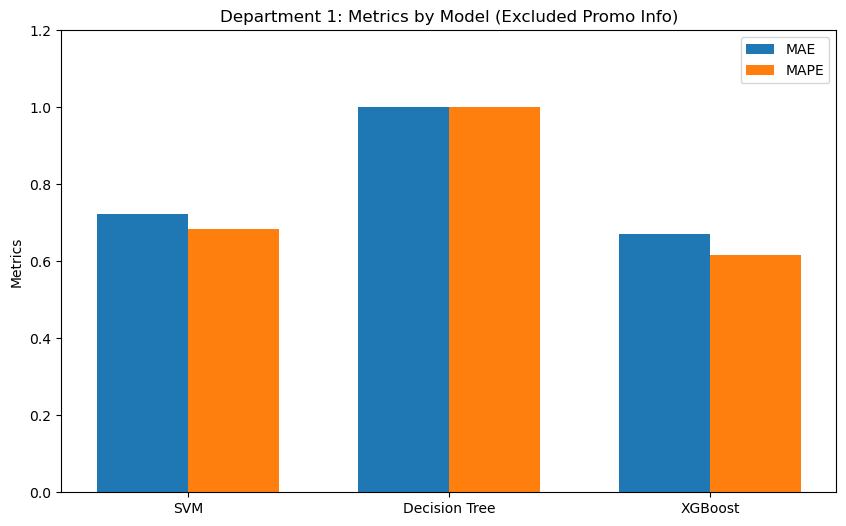

In [20]:
scalled_x_train_d1 = scalled_x_train[0]
scalled_x_test_d1 = scalled_x_test[0]
y_train_d1 = y_train[0]
y_test_d1 = y_test[0]
print('Department 1, Evaluation on Test set:\n')
results_d1_no_promo = evaluate_models(scalled_x_train_d1,y_train_d1,scalled_x_test_d1,y_test_d1,best_params_d1)
plot_results(results_d1_no_promo,'1',promo)

### Dept 2

Department 2, Evaluation on Test set:

SVM model has MAE: 723.464 and MAPE: 0.0453
Decision Tree model has MAE: 719.3781 and MAPE: 0.0455
XGBoost model has MAE: 820.4272 and MAPE: 0.0517


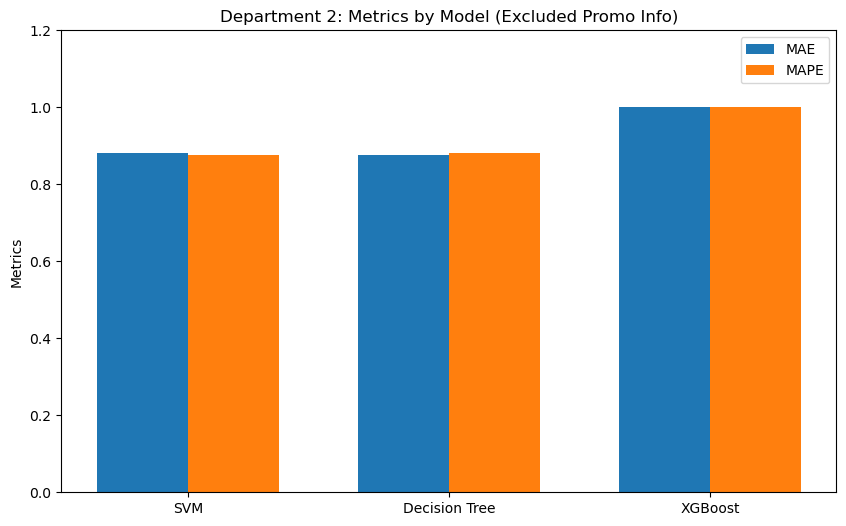

In [21]:
scalled_x_train_d2 = scalled_x_train[1]
scalled_x_test_d2 = scalled_x_test[1]
y_train_d2 = y_train[1]
y_test_d2 = y_test[1]
print('Department 2, Evaluation on Test set:\n')
results_d2_no_promo = evaluate_models(scalled_x_train_d2,y_train_d2,scalled_x_test_d2,y_test_d2,best_params_d2)
plot_results(results_d2_no_promo,'2',promo)

### Dept 5

Department 5, Evaluation on Test set:

SVM model has MAE: 303.5123 and MAPE: 0.2321
Decision Tree model has MAE: 357.503 and MAPE: 0.2832
XGBoost model has MAE: 422.1815 and MAPE: 0.3098


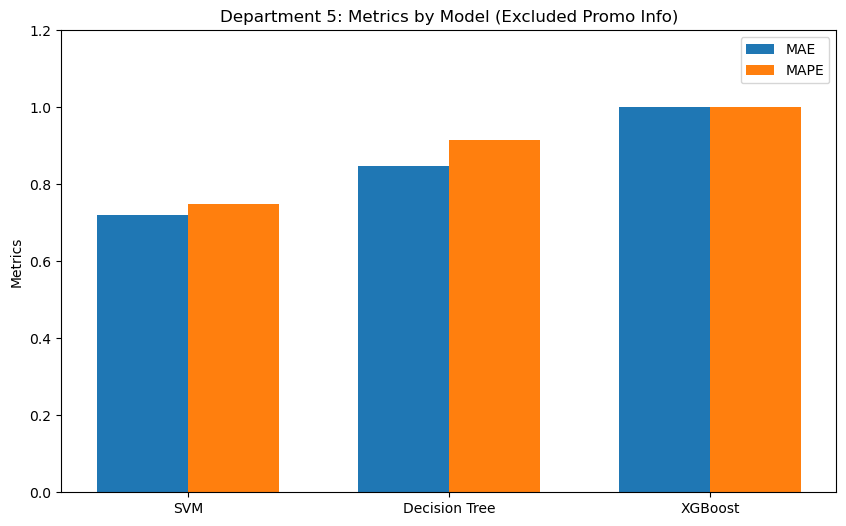

In [22]:
scalled_x_train_d5 = scalled_x_train[2]
scalled_x_test_d5 = scalled_x_test[2]
y_train_d5 = y_train[2]
y_test_d5 = y_test[2]
print('Department 5, Evaluation on Test set:\n')
results_d5_no_promo = evaluate_models(scalled_x_train_d5,y_train_d5,scalled_x_test_d5,y_test_d5,best_params_d5)
plot_results(results_d5_no_promo,'5',promo)

## Pipeline Using Promo Information

## Data Preprocessing

In [23]:
promo = 'Promo'
with open('dataset_object_v1.pkl', 'rb') as inp:
    df_list = pickle.load(inp)
df_list = create_moving_averages(df_list)
df_list = create_trigonometric_columns(df_list)
df_list = delete_useless_cols(df_list,promo)

## Validation Split

In [24]:
train_list,val_list = train_val_split(df_list)
x_train,y_train,x_val,y_val = splits_X_y(train_list,val_list)
scalled_x_train,scalled_x_val,df_x_train,df_x_test = scaller(x_train,x_val)

## Hyper-Parameters Tunning

### Dept 1

In [25]:
scalled_x_train_d1 = scalled_x_train[0]
scalled_x_val_d1 = scalled_x_val[0]
y_train_d1 = y_train[0]
y_val_d1 = y_val[0]
print('Department 1, Validation Experiment:')
best_params_d1 = parameter_tuning_validation(scalled_x_train_d1,y_train_d1,scalled_x_val_d1,y_val_d1)
print ('\nBest Parameters for SVR:',best_params_d1[0])
print ('Best Parameters for DecisionTreeRegressor:',best_params_d1[1])
print ('Best Parameters for XGBRegressor:',best_params_d1[2])

Department 1, Validation Experiment:


Experiment 1 with SVR using kernel=linear, C=0.1, gamma=scale has MAE: 2002.5544 and MAPE: 0.1402
Experiment 2 with SVR using kernel=linear, C=0.1, gamma=auto has MAE: 2002.5544 and MAPE: 0.1402
Experiment 3 with SVR using kernel=linear, C=10, gamma=scale has MAE: 1813.9158 and MAPE: 0.1306
Experiment 4 with SVR using kernel=linear, C=10, gamma=auto has MAE: 1813.9158 and MAPE: 0.1306
Experiment 5 with SVR using kernel=linear, C=15, gamma=scale has MAE: 1834.0743 and MAPE: 0.135
Experiment 6 with SVR using kernel=linear, C=15, gamma=auto has MAE: 1834.0743 and MAPE: 0.135
Experiment 7 with SVR using kernel=sigmoid, C=0.1, gamma=scale has MAE: 2007.7361 and MAPE: 0.1406
Experiment 8 with SVR using kernel=sigmoid, C=0.1, gamma=auto has MAE: 2007.8053 and MAPE: 0.1406
Experiment 9 with SVR using kernel=sigmoid, C=10, gamma=scale has MAE: 1979.7076 and MAPE: 0.1383
Experiment 10 with SVR using kernel=sigmoid, C=10, gamma=auto has MAE: 1986.6284 and MA

### Dept 2

In [26]:
scalled_x_train_d2 = scalled_x_train[1]
scalled_x_val_d2 = scalled_x_val[1]
y_train_d2 = y_train[1]
y_val_d2 = y_val[1]
print('Department 2, Validation Experiment:')
best_params_d2 = parameter_tuning_validation(scalled_x_train_d2,y_train_d2,scalled_x_val_d2,y_val_d2)
print ('\nBest Parameters for SVR:',best_params_d2[0])
print ('Best Parameters for DecisionTreeRegressor:',best_params_d2[1])
print ('Best Parameters for XGBRegressor:',best_params_d2[2])

Department 2, Validation Experiment:


Experiment 1 with SVR using kernel=linear, C=0.1, gamma=scale has MAE: 759.5348 and MAPE: 0.0462
Experiment 2 with SVR using kernel=linear, C=0.1, gamma=auto has MAE: 759.5348 and MAPE: 0.0462
Experiment 3 with SVR using kernel=linear, C=10, gamma=scale has MAE: 1373.8037 and MAPE: 0.0863
Experiment 4 with SVR using kernel=linear, C=10, gamma=auto has MAE: 1373.8037 and MAPE: 0.0863
Experiment 5 with SVR using kernel=linear, C=15, gamma=scale has MAE: 1517.3116 and MAPE: 0.0951
Experiment 6 with SVR using kernel=linear, C=15, gamma=auto has MAE: 1517.3116 and MAPE: 0.0951
Experiment 7 with SVR using kernel=sigmoid, C=0.1, gamma=scale has MAE: 762.1011 and MAPE: 0.0463
Experiment 8 with SVR using kernel=sigmoid, C=0.1, gamma=auto has MAE: 762.1175 and MAPE: 0.0463
Experiment 9 with SVR using kernel=sigmoid, C=10, gamma=scale has MAE: 754.9063 and MAPE: 0.0461
Experiment 10 with SVR using kernel=sigmoid, C=10, gamma=auto has MAE: 755.3563 and MAPE: 

### Dept 5

In [27]:
scalled_x_train_d5 = scalled_x_train[2]
scalled_x_val_d5 = scalled_x_val[2]
y_train_d5 = y_train[2]
y_val_d5 = y_val[2]
print('Department 2, Validation Experiment:')
best_params_d5 = parameter_tuning_validation(scalled_x_train_d5,y_train_d5,scalled_x_val_d5,y_val_d5)
print ('\nBest Parameters for SVR:',best_params_d5[0])
print ('Best Parameters for DecisionTreeRegressor:',best_params_d5[1])
print ('Best Parameters for XGBRegressor:',best_params_d5[2])

Department 2, Validation Experiment:


Experiment 1 with SVR using kernel=linear, C=0.1, gamma=scale has MAE: 280.2205 and MAPE: 0.2529
Experiment 2 with SVR using kernel=linear, C=0.1, gamma=auto has MAE: 280.2205 and MAPE: 0.2529
Experiment 3 with SVR using kernel=linear, C=10, gamma=scale has MAE: 348.228 and MAPE: 0.3635
Experiment 4 with SVR using kernel=linear, C=10, gamma=auto has MAE: 348.228 and MAPE: 0.3635
Experiment 5 with SVR using kernel=linear, C=15, gamma=scale has MAE: 351.6478 and MAPE: 0.359
Experiment 6 with SVR using kernel=linear, C=15, gamma=auto has MAE: 351.6478 and MAPE: 0.359
Experiment 7 with SVR using kernel=sigmoid, C=0.1, gamma=scale has MAE: 284.5744 and MAPE: 0.2574
Experiment 8 with SVR using kernel=sigmoid, C=0.1, gamma=auto has MAE: 284.6117 and MAPE: 0.2575
Experiment 9 with SVR using kernel=sigmoid, C=10, gamma=scale has MAE: 273.4182 and MAPE: 0.2442
Experiment 10 with SVR using kernel=sigmoid, C=10, gamma=auto has MAE: 274.534 and MAPE: 0.2477
Ex

## Evalaution on Test Set

### Train-Test Split

In [28]:
train_list,test_list = train_test_split(df_list)
x_train,y_train,x_test,y_test = splits_X_y(train_list,test_list)
scalled_x_train,scalled_x_test,df_x_train,df_x_test = scaller(x_train,x_test)
final_df = save_final_df(df_x_train,y_train,df_x_test,y_test)

### Dept 1

Department 1, Evaluation on Test set:

SVM model has MAE: 2896.4553 and MAPE: 0.2741
Decision Tree model has MAE: 3770.615 and MAPE: 0.3783
XGBoost model has MAE: 2693.0168 and MAPE: 0.2518


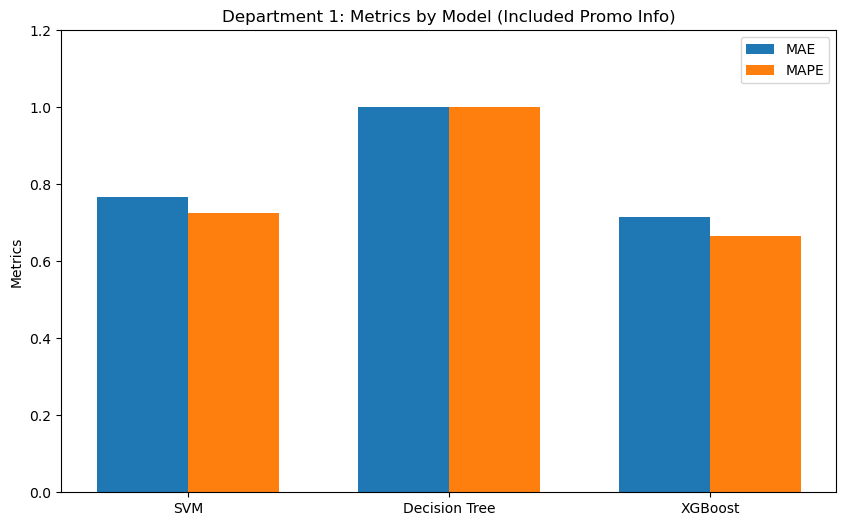

In [29]:
scalled_x_train_d1 = scalled_x_train[0]
scalled_x_test_d1 = scalled_x_test[0]
y_train_d1 = y_train[0]
y_test_d1 = y_test[0]
print('Department 1, Evaluation on Test set:\n')
results_d1 = evaluate_models(scalled_x_train_d1,y_train_d1,scalled_x_test_d1,y_test_d1,best_params_d1)
plot_results(results_d1,'1',promo)

### Dept 2

Department 2, Evaluation on Test set:

SVM model has MAE: 723.9362 and MAPE: 0.0453
Decision Tree model has MAE: 719.3781 and MAPE: 0.0455
XGBoost model has MAE: 836.6152 and MAPE: 0.0526


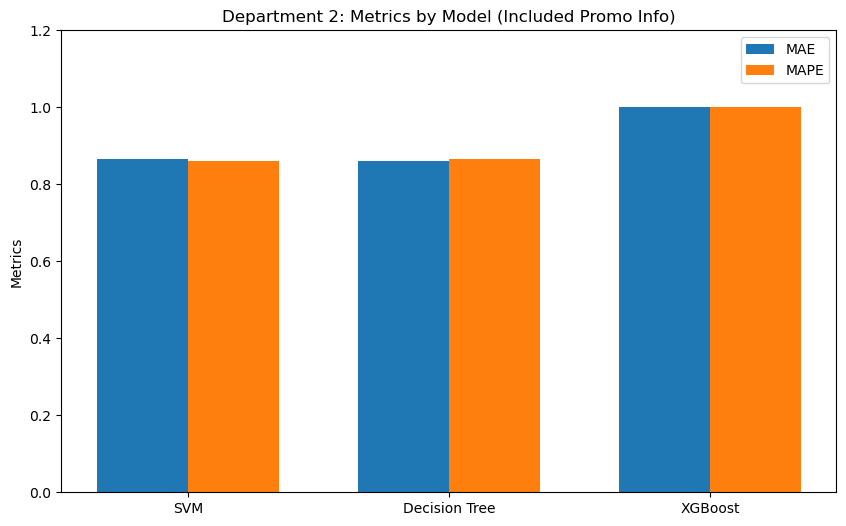

In [30]:
scalled_x_train_d2 = scalled_x_train[1]
scalled_x_test_d2 = scalled_x_test[1]
y_train_d2 = y_train[1]
y_test_d2 = y_test[1]
print('Department 2, Evaluation on Test set:\n')
results_d2 = evaluate_models(scalled_x_train_d2,y_train_d2,scalled_x_test_d2,y_test_d2,best_params_d2)
plot_results(results_d2,'2',promo)

### Dept 5

Department 5, Evaluation on Test set:

SVM model has MAE: 301.1344 and MAPE: 0.2319
Decision Tree model has MAE: 357.503 and MAPE: 0.2832
XGBoost model has MAE: 422.1815 and MAPE: 0.3098


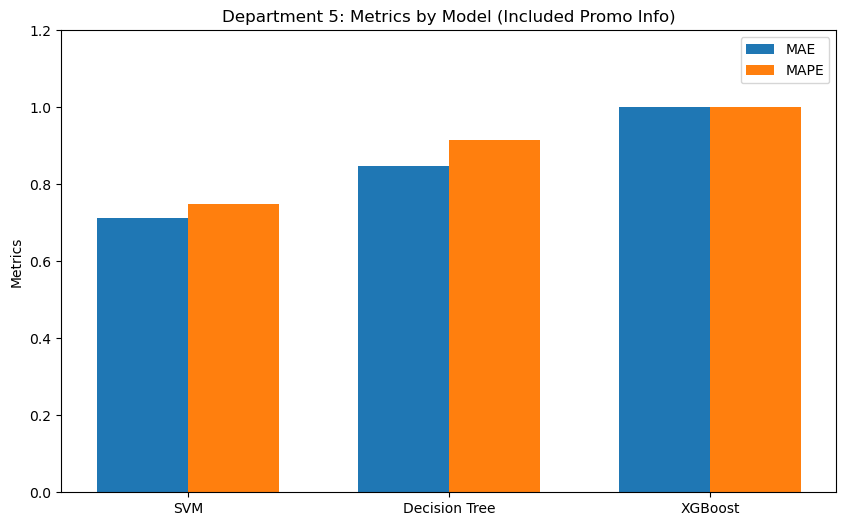

In [31]:
scalled_x_train_d5 = scalled_x_train[2]
scalled_x_test_d5 = scalled_x_test[2]
y_train_d5 = y_train[2]
y_test_d5 = y_test[2]
print('Department 5, Evaluation on Test set:\n')
results_d5 = evaluate_models(scalled_x_train_d5,y_train_d5,scalled_x_test_d5,y_test_d5,best_params_d5)
plot_results(results_d5,'5',promo)

## Summarize Promo Influence

### Dept 1

In [32]:
print ('Results without using Promo:')
print ('SVM:',results_d1_no_promo['SVM'])
print ('Decision Tree:',results_d1_no_promo['Decision Tree'])
print ('XGBoost:',results_d1_no_promo['XGBoost'])
print ('\nResults using Promo:')
print ('SVM:',results_d1['SVM'])
print ('Decision Tree:',results_d1['Decision Tree'])
print ('XGBoost:',results_d1['XGBoost'])

Results without using Promo:
SVM: {'MAE': 2723.579, 'MAPE': 0.2588}
Decision Tree: {'MAE': 3770.615, 'MAPE': 0.3783}
XGBoost: {'MAE': 2532.1519, 'MAPE': 0.2336}

Results using Promo:
SVM: {'MAE': 2896.4553, 'MAPE': 0.2741}
Decision Tree: {'MAE': 3770.615, 'MAPE': 0.3783}
XGBoost: {'MAE': 2693.0168, 'MAPE': 0.2518}


### Dept 2

In [33]:
print ('Results without using Promo:')
print ('SVM:',results_d2_no_promo['SVM'])
print ('Decision Tree:',results_d2_no_promo['Decision Tree'])
print ('XGBoost:',results_d2_no_promo['XGBoost'])
print ('\nResults using Promo:')
print ('SVM:',results_d2['SVM'])
print ('Decision Tree:',results_d2['Decision Tree'])
print ('XGBoost:',results_d2['XGBoost'])

Results without using Promo:
SVM: {'MAE': 723.464, 'MAPE': 0.0453}
Decision Tree: {'MAE': 719.3781, 'MAPE': 0.0455}
XGBoost: {'MAE': 820.4272, 'MAPE': 0.0517}

Results using Promo:
SVM: {'MAE': 723.9362, 'MAPE': 0.0453}
Decision Tree: {'MAE': 719.3781, 'MAPE': 0.0455}
XGBoost: {'MAE': 836.6152, 'MAPE': 0.0526}


### Dept 5

In [34]:
print ('Results without using Promo:')
print ('SVM:',results_d5_no_promo['SVM'])
print ('Decision Tree:',results_d5_no_promo['Decision Tree'])
print ('XGBoost:',results_d5_no_promo['XGBoost'])
print ('\nResults using Promo:')
print ('SVM:',results_d5['SVM'])
print ('Decision Tree:',results_d5['Decision Tree'])
print ('XGBoost:',results_d5['XGBoost'])

Results without using Promo:
SVM: {'MAE': 303.5123, 'MAPE': 0.2321}
Decision Tree: {'MAE': 357.503, 'MAPE': 0.2832}
XGBoost: {'MAE': 422.1815, 'MAPE': 0.3098}

Results using Promo:
SVM: {'MAE': 301.1344, 'MAPE': 0.2319}
Decision Tree: {'MAE': 357.503, 'MAPE': 0.2832}
XGBoost: {'MAE': 422.1815, 'MAPE': 0.3098}
